In [ ]:
import sklearn
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from vflow import Vset, init_args, dict_to_df, perturbation_stats
from vflow.pipeline import build_graph
import matplotlib.pyplot as plt
import ray

In [ ]:
X, y = make_classification() # make sample dataset
X_train, X_test, y_train, y_test = init_args(
    train_test_split(X, y, test_size=0.2),
    names=["X_train", "X_test", "y_train", "y_test"],  # optionally name the args
)

In [ ]:
X_train

{(X_train,): array([[ 3.09002095,  1.07164149,  1.27756064, ...,  0.50554103,
         -1.17279936, -0.03623674],
        [-1.71827608,  0.64109107, -1.03750901, ..., -0.05671554,
         -0.41822261,  0.84135401],
        [-0.79616767, -1.12715551,  3.0047138 , ..., -0.33149386,
          0.44645297, -0.98422561],
        ...,
        [-1.33914552, -0.64866912,  0.34748781, ...,  0.42132544,
          1.54922865, -1.51456707],
        [ 1.61139232, -0.37020019, -0.7572106 , ..., -0.83326925,
          0.60736278, -0.19510879],
        [-0.1878855 ,  0.22839174, -0.10599877, ..., -0.16045126,
         -1.74348162, -1.62840184]]),
 '__prev__': ('init',)}

In [ ]:
subsampling_funcs = [sklearn.utils.resample for _ in range(3)]
subsampling_set = Vset(
    name="subsampling", vfuncs=subsampling_funcs, output_matching=True
)
# output_matching=True so that the Vset will have the same outputs on training
# and test data
subsampling_set

In [ ]:
X_trains, y_trains = subsampling_set(X_train, y_train)
X_trains

{(X_train,
  subsampling_0): array([[ 1.27486871, -0.46825616, -0.67674159, ...,  1.07035033,
         -1.95272669, -1.30705649],
        [-1.36030675,  0.67528193, -0.76452466, ...,  0.02158205,
         -0.59566   ,  1.01273582],
        [ 0.87303445,  0.95955919, -0.99414447, ...,  0.92692961,
          0.5402778 , -1.10930665],
        ...,
        [-1.43033977, -1.16120435, -0.15644604, ..., -1.83350341,
         -0.24300009,  0.35471554],
        [-2.08763387,  0.18120732,  0.20995563, ...,  0.09314141,
         -0.55744315,  0.08376006],
        [-0.1878855 ,  0.22839174, -0.10599877, ..., -0.16045126,
         -1.74348162, -1.62840184]]),
 (X_train,
  subsampling_1): array([[-1.06545538,  1.36427481, -0.6625831 , ...,  1.26754791,
         -0.2298068 ,  1.605535  ],
        [-1.58529328, -1.40875492, -0.26035977, ...,  0.46688543,
         -0.05807849,  0.50538036],
        [ 0.83116706,  1.71994096,  0.24709081, ...,  0.53318922,
          0.60529407, -0.36249084],
        ...

In [ ]:
y_trains

{(y_train,
  subsampling_0): array([1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]),
 (y_train,
  subsampling_1): array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]),
 (y_train,
  subsampling_2): array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1]),
 '__prev__': (<vflow.vset.Vset at 0x722ebcdf95e0>, ('init',))}

In [ ]:
# define a Vset of models
models = [LogisticRegression(), DecisionTreeClassifier()]


# create a Vset of models. is_async=True so that the models are fit in parallel
modeling_set = Vset(name="modeling", vfuncs=models, vfunc_keys=["LR", "DT"], is_async=True)

# fit the models

# create a Ray cluster with 4 cpus
ray.init(num_cpus=4)
modeling_set.fit(X_trains, y_trains)
preds_test = modeling_set.predict(X_test)
ray.shutdown()
preds_test

2024-11-01 10:49:34,865	INFO worker.py:1816 -- Started a local Ray instance.


{(X_test,
  X_train,
  subsampling_0,
  y_train,
  LR): array([1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]),
 (X_test,
  X_train,
  subsampling_1,
  y_train,
  LR): array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]),
 (X_test,
  X_train,
  subsampling_2,
  y_train,
  LR): array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]),
 (X_test,
  X_train,
  subsampling_0,
  y_train,
  DT): array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 (X_test,
  X_train,
  subsampling_1,
  y_train,
  DT): array([1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]),
 (X_test,
  X_train,
  subsampling_2,
  y_train,
  DT): array([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0]),
 '__prev__': (<vflow.vset.Vset at 0x722ebcdfb950>, ('init',))}

In [ ]:
# get metrics
binary_metrics_set = Vset(
    name="binary_metrics",
    vfuncs=[accuracy_score, balanced_accuracy_score],
    vfunc_keys=["Acc", "Bal_Acc"],
)
binary_metrics = binary_metrics_set.evaluate(preds_test, y_test)
binary_metrics

{(X_test, X_train, subsampling_0, y_train, LR, y_test, Acc): 0.7,
 (X_test, X_train, subsampling_1, y_train, LR, y_test, Acc): 0.75,
 (X_test, X_train, subsampling_2, y_train, LR, y_test, Acc): 0.7,
 (X_test, X_train, subsampling_0, y_train, DT, y_test, Acc): 0.7,
 (X_test, X_train, subsampling_1, y_train, DT, y_test, Acc): 0.85,
 (X_test, X_train, subsampling_2, y_train, DT, y_test, Acc): 0.9,
 (X_test,
  X_train,
  subsampling_0,
  y_train,
  LR,
  y_test,
  Bal_Acc): np.float64(0.7070707070707071),
 (X_test,
  X_train,
  subsampling_1,
  y_train,
  LR,
  y_test,
  Bal_Acc): np.float64(0.75),
 (X_test,
  X_train,
  subsampling_2,
  y_train,
  LR,
  y_test,
  Bal_Acc): np.float64(0.696969696969697),
 (X_test,
  X_train,
  subsampling_0,
  y_train,
  DT,
  y_test,
  Bal_Acc): np.float64(0.7070707070707071),
 (X_test,
  X_train,
  subsampling_1,
  y_train,
  DT,
  y_test,
  Bal_Acc): np.float64(0.8500000000000001),
 (X_test,
  X_train,
  subsampling_2,
  y_train,
  DT,
  y_test,
  Bal_A

In [ ]:
df = dict_to_df(binary_metrics)
df

,init-subsampling,init-subsampling,subsampling,init-modeling,modeling,init-binary_metrics,binary_metrics,out
0,X_test,X_train,subsampling_0,y_train,LR,y_test,Acc,0.700000
1,X_test,X_train,subsampling_1,y_train,LR,y_test,Acc,0.750000
2,X_test,X_train,subsampling_2,y_train,LR,y_test,Acc,0.700000
3,X_test,X_train,subsampling_0,y_train,DT,y_test,Acc,0.700000
4,X_test,X_train,subsampling_1,y_train,DT,y_test,Acc,0.850000
5,X_test,X_train,subsampling_2,y_train,DT,y_test,Acc,0.900000
6,X_test,X_train,subsampling_0,y_train,LR,y_test,Bal_Acc,0.707071
7,X_test,X_train,subsampling_1,y_train,LR,y_test,Bal_Acc,0.750000
8,X_test,X_train,subsampling_2,y_train,LR,y_test,Bal_Acc,0.696970
9,X_test,X_train,subsampling_0,y_train,DT,y_test,Bal_Acc,0.707071


In [ ]:
perturbation_stats(df, 'modeling', 'binary_metrics')

,modeling,binary_metrics,count,mean,std
0,DT,Acc,3,0.816667,0.104083
1,DT,Bal_Acc,3,0.818687,0.099718
2,LR,Acc,3,0.716667,0.028868
3,LR,Bal_Acc,3,0.718013,0.028158


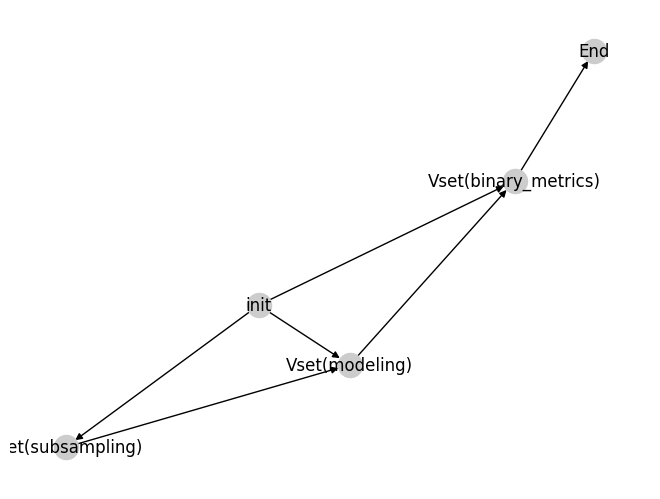

In [ ]:
G = build_graph(binary_metrics, draw=True)
plt.show()